In [24]:
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import os
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct):
        import numpy as np
        duration=0.05
        run+=30000
        rng = GSLRandomNumberGenerator()
        rng.seed(run)
        rm = 0.005
        voxelr=rm
        r0=0.256318
        if correct==True:
            voxelr=rm*1.0208582  #1.017#1.0196#1.0208582  
        factor =700
        L = factor*rm
        D = 1.
        kd= 4.0*math.pi*D*2*rm
        ka = kaf*kd
        #ka = (1./r0-1)*6*2**0.5*D*voxelr*kaa/kd
        kon = (ka*kd)/(ka+kd)
        tm =(2*voxelr)**2/(6*D)
        #N = 4000
        Na=4000
        Nb=4000
        #dt=tm
        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
        (c,r,l)=w.shape()
        l1,l2,l3=w.actual_lengths()
        Vac=l1*l2*l3
        Nev=(c - 2) * (r - 2) * (l - 2)
        #print('Nv',Nev,L**3/4/2**0.5/voxelr**3,Vac)
        vv = w.calculate_voxel_volume(voxelr)
        #phi = 2.*N/Nev
        #print('ka,kd,kon,L,dur,N,phi',ka,kd,kon,L,duration,N,phi)

        with species_attributes():
            A |  {'D': str(0), 'radius':str(voxelr)}
            B |  {'D': str(D), 'radius':str(voxelr)}

        with reaction_rules():#for spa and egfrd
            A + B > B | ka

        m2 = get_model()

        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
        w.bind_to(m2)
        w.add_molecules(Species('A'), Na)
        w.add_molecules(Species('B'), Nb)
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        dt = tm#sim.dt()
        tlog = dt
        tlogs=[]
        nlog=[]
        Prxn = ka/(3*2**0.5*D*2*voxelr)      
        #print(dt,tm,tm/dt,Prxn)
        while sim.t()<duration:
            if sim.t()>=tlog:
                tlogs.append(sim.t())
                nlog.append(w.num_particles_exact(Species('A')))
                tlog+=dt
            sim.step()
        if correct==True:
            folder='/home/chew/outputdata/keffc/kfac{}_{}_{}_{}/'.format(kaf,factor,Na,Nb)
            name = folder+'run'+str(run)
            if not os.path.exists(folder):
                os.makedirs(folder)
        else:
            name = '/home/chew/outputdata/keff/kfac{}_{}_{}_{}/run{}'.format(kaf,factor,Na,Nb,run)
        filename=open(name,'w')
        np.savetxt(name,np.column_stack((tlogs,nlog)),delimiter=',',fmt='%s')
        filename.close()  
        return
    job.update({'run':task_id})
    out=singlerun(**job)

    return out    
        
#singlerun(0.1,0,True)
simrun=20000#00#00
nproc=350
kafs=[100]
cor=True #correction true?
for kaf in kafs:
    jobs=[{'kaf':kaf,'correct':cor}]
    #res=ensemble.run_sge(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]
    #res=ensemble.run_slurm(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]#,extra_args=['--mail-user=wxchew@gmail.com', '--mail-type=ALL'])[0]
    #res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]
print('finish')

finish


In [60]:
pp =np.array([[3997, 3995, 3992, 3992, 3992],
[3997, 3995, 3994, 3992, 3990],
[3994, 3994, 3994, 3991, 3989],
[3993, 3991, 3990, 3990, 3988],
[3998, 3995, 3993, 3993, 3991]])
print(np.mean(pp,axis=0))

[ 3995.8  3994.   3992.6  3991.6  3990. ]


In [59]:
(3997+3997+3994+3993+3998)/5

3995.8

In [37]:
Afitted=0.124666
Bfitted=0.00564379
rm = 0.005  
D = 1
f=1.0208582
kd= 4.0*math.pi*D*2*rm
ka = 100*kd
r0=0.256318
f=1.0208582
Prxn = ka/(3*2**0.5*D*2*f*rm) 
L=1.#350*rm*2
w = spatiocyte.SpatiocyteWorld(ones()*L,f*rm)
(c,r,l)=w.shape()
l1,l2,l3=w.actual_lengths()
Vac=l1*l2*l3
Nev=(c - 2) * (r - 2) * (l - 2)
print(Nev)
kap = 3*D*Prxn*Vac/Nev/2/(rm*f)**2
er = lambda x,y: (x-y)*100/x
keffl=kap/(1+Prxn*(0.34466))
print(er(ka,kap),er(Afitted,keffl))

1390800
5.654319433712918e-14 0.19750868957495077


In [38]:
8000*100/7292800,8000*100/57776864,2000*100/1390800

(0.10969723562966213, 0.013846372831865711, 0.1438021282714984)

In [32]:
V=1
f=1.0208582
cc=V/(1390800*(0.005*f)**3)
r0=0.256318
f2 =16*math.pi/3/cc/(1/r0-1)
print(f2)
print(5.406659758248262/4/2**0.5)
print(V/(1390800*(0.005*f)**3),V/(1329287*(0.005*f)**3),4*2**0.5)
print()

1.068098723667085
0.9557714446564414
5.406659758248262 5.656853931296765 5.656854249492381


In [3]:
def getrtime(res):
    #st is start time
    dat = np.array(res)
    kon=dat[0][1]
    print(kon)
    #c1=dat[0][2]
    c2=dat[0][3]
    #mksim = []
    rxntime=[]
    #taus=[]
    for i in range(simrun):
        hist=np.array(dat[i][0])
        #indx = np.where(hist[:,0]>st)[0][0]
        #tau = np.dot(hist[indx:,0],hist[indx:,1])/sum(hist[indx:,1])
        #taus.append(tau)
        #ksim=1./tau/c2
        #mksim.append(ksim)
        for x,y in zip(hist[:,0],hist[:,1]):
            for k in [x]*int(y):
                rxntime.append(k)
    #mtau=np.mean(taus)
    return np.array(rxntime),kon,c2

def getk(rxntime,frm,until,res):
    #res is hist resolution
    hi,be=np.histogram(rxntime,bins=np.arange(min(rxntime),max(rxntime),res))
    hi = hi/simrun/1000
    print('sum',sum(hi))
    midpnt = (be[1:]+be[:-1])*0.5
    indx = (until>midpnt)*(midpnt>frm)
    N0=int(1000*(1-sum(hi[midpnt<=frm])))
    hi = hi[indx]
    midpnt = midpnt[indx]
    print('N0',N0)
    tini = midpnt[0]
    hi = hi/hi[0]
    midpnt = midpnt-midpnt[0]
    plt.plot(midpnt,(hi),'.')
    
    fit=np.polyfit(midpnt, np.log(hi), 1)
    print('fit',fit)
    vol = 1000./c2

    
    C=math.exp(fit[1])
    t=np.linspace(midpnt[0],midpnt[-1],100)
    plt.plot(t,[C*math.exp(fit[0]*m) for m in t],'r-')
    kfit = -fit[0]/N0
    mt = -kon*N0
    #print(mt,C,1./mt)
    plt.semilogy(t,[math.exp(mt*m) for m in t],'k--')
    #meantau=np.mean(rxntime[rxntime>st])
    #meanksim = 1./mtau/c2
    print('kon,kfit,err',kon,kfit,error(kon,kfit))
    fig=plt.gcf()
    fig.set_size_inches(12, 8)
    plt.xlabel('rxn time')
    plt.ylabel('frequency')
    #print(mean1,mean2,kon,error(kon,mean1),error(kon,mean2))s

def getst(res,frm,until,dt):
    #st is start time
    dat = np.array(res)
    kon=dat[0][1]
    #c1=dat[0][2]
    c2=dat[0][3]
    #mksim = []
    rxntime=[]
    #taus=[]
    tlist = np.arange(0,until,dt)
    mNa = np.zeros(len(tlist))
    
    for i in range(1):#simrun):
        Na = np.zeros(len(tlist))
        count = np.zeros(len(tlist))
        Nat = [1000]
        time = [0]        
        hist=np.array(dat[i][0])
        Nc = Nat[0]
        for x,y in zip(hist[:,0],hist[:,1]):
            Nc = Nc -y
            if x<until:
                indx=np.where(tlist>=x)
                if len(indx[0])!=0:
                    indx=indx[0][0]
                    Na[indx]+=Nc
                    count[indx]+=1.
                #Nat.append(Nc)
        for i,j in enumerate(count):
            if j!=0:
                count[i]=1./j
        mNa+=count*Na/1000
       
    mNa = mNa/1
    mNa[0]=1
    tlist=tlist[mNa!=0]
    mNa=mNa[mNa!=0]
    plt.semilogy(tlist,mNa,'.')
    inx=tlist>frm
    fit=np.polyfit(tlist[inx], np.log(mNa[inx]), 1)
    print(fit)
    ksim=-fit[0]/c2
    error = lambda x,y: (x-y)*100/x
    print('ksim',ksim,'kon',kon,error(kon,ksim))
    plt.plot(tlist[inx],[np.exp(fit[0]*t) for t in tlist[inx]],'r-')
    #plt.semilogy(tlist,mNa,'.')
    #mtau=np.mean(taus)

    return mNa,tlist
#time01=getrtime(res,0.01)
#time1,kon,c2=getrtime(res,0.01)


[-120.82757547   -0.15281866]
ksim 0.126418900822 kon 0.12441951103325916 -1.60697447894


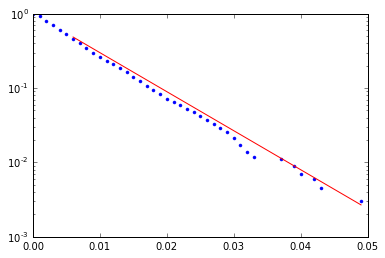

In [4]:
Na,tt=getst(res100,0.005,0.05,0.001)

In [5]:
Na,tt=getst(res1,0.02,0.07,0.001)

NameError: name 'res1' is not defined

[ -1.10327833e+01   1.07949415e-03]
ksim 0.0115433280051 kon 0.01142397328578107 -1.0447741459


(0.01, 1.1)

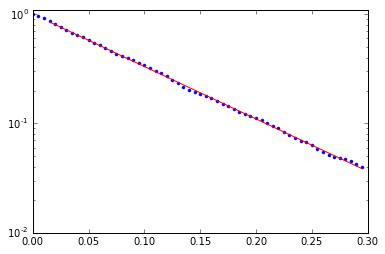

In [794]:
Na,tt=getst(res01,0.01,0.3,0.005)
plt.ylim(0.01,1.1)

In [723]:
96158./102

942.7254901960785

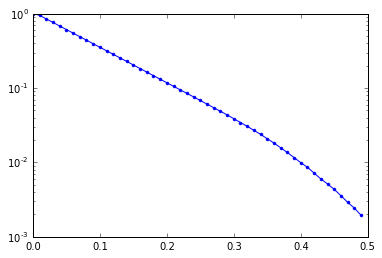

In [687]:
plt.semilogy(tt,Na,'.-')

In [513]:
time100,kon,c2=getrtime(res100,0.0)

0.12441951103325916


sum 0.9997048
ini 0.5016942 0.00250005986478 1000
[ -1.25214817e+02  -1.24419283e-01]
0.8830095319699895
0.12441951103325916 0.125214816642 -0.639212935549


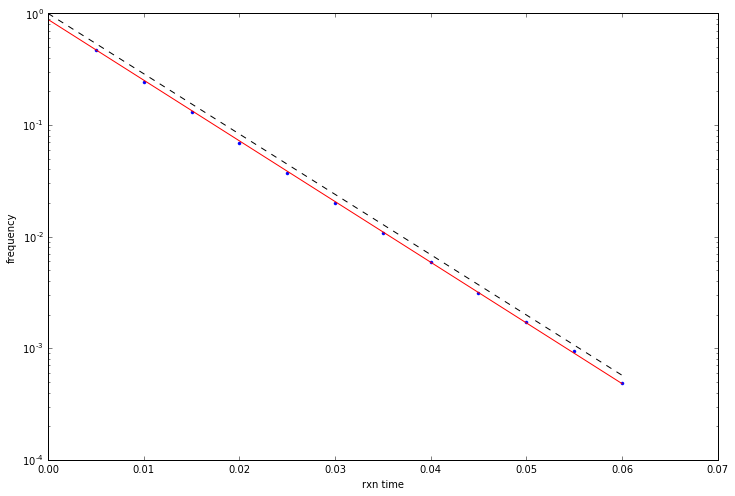

In [505]:
getk(time100,0.07,0.005)

In [524]:
time1,kon,c2=getrtime(res1,0.0)
getk(time1,0.15,0.005)

TypeError: getrtime() takes 1 positional argument but 2 were given

0.01142397328578107
sum 0.9999998
N0 895
fit [ -1.09435133e+01  -8.47860562e-03]
kon,kfit,err 0.01142397328578107 0.0122273891266 -7.03271813347


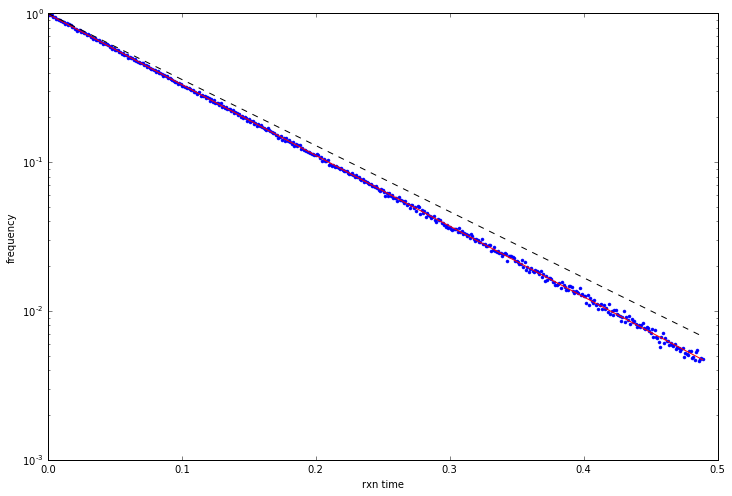

In [550]:
time01,kon,c2=getrtime(res01)
getk(time01,0.01,0.5,0.001)

In [32]:
mean1 = np.mean(np.array(res)[:,0])
mean2 = np.mean(np.array(res)[:,1])
kon=res[0][-1]
error = lambda x,y: (x-y)*100/x
print(teq)
print(mean1,mean2,kon,error(kon,mean1),error(kon,mean2))

0.002
0.0109638671168 0.0114712227259 0.01142397328578107 4.02754941312 -0.413599007844


In [23]:
print(,teq)
print(mean1,mean2,kon,error(kon,mean1),error(kon,mean2))

0.05 0.01
0.0109063752349 0.0114110703933 0.01142397328578107 4.53080585867 0.112945751749


In [4]:
#new logging
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct):
        import numpy as np
        duration =0.01 #0.12 for kfac1, 0.1 for kfac100
        rng = GSLRandomNumberGenerator()
        #run+=1000
        rng.seed(run)
        rm = 0.005
        voxelr=rm
        if correct==True:
            voxelr=rm*1.0208582  
        #r0=0.256318
        L = 350*rm
        D = 1
        kd= 4.0*math.pi*D*2*rm
        ka = kaf*kd
        #ka = (1./r0-1)*6*2**0.5*D*voxelr*kaa/kd
        kon = (ka*kd)/(ka+kd)
        tm =(2*voxelr)**2/(6*D)
        N = 4000
        dt=tm
        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
        Vr = w.calculate_volume(ones()*L,voxelr)
        lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
        Nv = lx*ly*lz
        vv = w.calculate_voxel_volume(voxelr)
        phi = 2.*N/Nv
        #print 'ka,kd,kon,L,dur,N',ka,kd,kon,L,duration,N

        with species_attributes():
            A |  {'D': str(0), 'radius':str(voxelr)}
            B |  {'D': str(D), 'radius':str(voxelr)}

        with reaction_rules():#for spa and egfrd
            A + B > B | ka

        m2 = get_model()

        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
        w.bind_to(m2)
        w.add_molecules(Species('A'), N)
        w.add_molecules(Species('B'), N)
        obs = FixedIntervalNumberObserver(dt, ('A'))
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        tlog = dt
        tlogs=[]
        nlog=[]
        Nlast = N
        while sim.t()<duration:
            Nac = w.num_particles_exact(Species('A'))
            dN = Nlast-Nac
            if dN!=0:
                tlogs.append(sim.t())
                nlog.append(Nac)
                Nlast=Nac
                #tlog+=dt
            sim.step()
        if correct==True:
            name = '/home/chew/outputdata/keffc/kfac'+str(kaf)+'/run'+str(run)
        else:
            name = '/home/chew/outputdata/keff/kfac'+str(kaf)+'/run'+str(run)
        filename=open(name,'w')
        np.savetxt(name,np.column_stack((tlogs,nlog)),delimiter=',',fmt='%s')
        filename.close()  
        return
        
    job.update({'run':task_id})
    out=singlerun(**job)

    return out

simrun=60#10000
nproc=60#300
kafs=[100]
cor=True #correction true?
for kaf in kafs:
    jobs=[{'kaf':kaf,'correct':cor}]
    #res=ensemble.run_sge(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]

    

In [1]:
#old logging
from ecell4 import *
%matplotlib inline
import numpy as np
import math
import sys
import matplotlib.pyplot as plt
from ecell4.extra import ensemble

def wrap(job,job_id,task_id):
    def singlerun(kaf,run,correct):
        import numpy as np
        duration =0.1 #0.12 for kfac1, 0.1 for kfac100
        rng = GSLRandomNumberGenerator()
        #run+=1000
        rng.seed(run)
        rm = 0.005
        voxelr=rm
        if correct==True:
            voxelr=rm*1.0208582  
        #r0=0.256318
        L = 350*rm
        D = 1
        kd= 4.0*math.pi*D*2*rm
        ka = kaf*kd
        #ka = (1./r0-1)*6*2**0.5*D*voxelr*kaa/kd
        kon = (ka*kd)/(ka+kd)
        tm =(2*voxelr)**2/(6*D)
        N = 4000
        dt=tm
        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
        Vr = w.calculate_volume(ones()*L,voxelr)
        lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
        Nv = lx*ly*lz
        vv = w.calculate_voxel_volume(voxelr)
        phi = 2.*N/Nv
        #print 'ka,kd,kon,L,dur,N',ka,kd,kon,L,duration,N

        with species_attributes():
            A |  {'D': str(0), 'radius':str(voxelr)}
            B |  {'D': str(D), 'radius':str(voxelr)}

        with reaction_rules():#for spa and egfrd
            A + B > B | ka

        m2 = get_model()

        w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
        w.bind_to(m2)
        w.add_molecules(Species('A'), N)
        w.add_molecules(Species('B'), N)
        obs = FixedIntervalNumberObserver(dt, ('A'))
        sim = spatiocyte.SpatiocyteSimulator(w)
        sim.initialize()
        tlog = dt
        tlogs=[]
        nlog=[]
        while sim.t()<duration:
            if sim.t()>=tlog:
                tlogs.append(sim.t())
                nlog.append(w.num_particles_exact(Species('A')))
                tlog+=dt
            sim.step()
        if correct==True:
            name = '/home/chew/outputdata/keffc/kfac'+str(kaf)+'/run'+str(run)
        else:
            name = '/home/chew/outputdata/keff/kfac'+str(kaf)+'/run'+str(run)
        filename=open(name,'w')
        np.savetxt(name,np.column_stack((tlogs,nlog)),delimiter=',',fmt='%s')
        filename.close()  
        return
        
    job.update({'run':task_id})
    out=singlerun(**job)

    return out

simrun=10000
nproc=300
kafs=[100]
cor=True #correction true?
for kaf in kafs:
    jobs=[{'kaf':kaf,'correct':cor}]
    #res=ensemble.run_sge(wrap,jobs,n=simrun,nproc=nproc,path='tmp',modules=('numpy','ecell4','math'))[0]
    res=ensemble.run_multiprocessing(wrap,jobs,n=simrun,nproc=nproc,modules=('numpy','ecell4','math'))[0]


Process Process-1:
Process Process-2:
Traceback (most recent call last):
  File "/home/chew/ecell4/build/local/lib/python3.5/site-packages/ecell-4.1.2-py3.5-linux-x86_64.egg/ecell4/extra/ensemble.py", line 32, in consumer
    res = (i, f(*x))
Traceback (most recent call last):
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 249, in _bootstrap
    self.run()
  File "/home/chew/ecell4/build/local/lib/python3.5/site-packages/ecell-4.1.2-py3.5-linux-x86_64.egg/ecell4/extra/ensemble.py", line 32, in consumer
    res = (i, f(*x))
  File "<ipython-input-1-bcb986c18952>", line 77, in wrap
    out=singlerun(**job)
  File "/usr/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-1-bcb986c18952>", li

KeyboardInterrupt: 

In [50]:
print(np.mean([33,43,43,47,45])) #False,rm
print(np.mean([40,37,38,37,27])) #true,rm
print(np.mean([33,43,45,47,43])) #False,rv
print(np.mean([47,44,33,45,51])) #true,rv

42.2
35.8
42.2
44.0


In [1]:
from ecell4 import *
import numpy as np
import math
import sys

run = int(sys.argv[2])
rng = GSLRandomNumberGenerator()
rng.seed(run)
k_factor = float(sys.argv[1])
#rm = 0.005
voxelr = 0.005#*1.0208582  
#r0=0.256318
L = 350*voxelr
D = 1
kd= 4.0*math.pi*D*2*voxelr
ka = k_factor*kd
#ka = (1./r0-1)*6*2**0.5*D*voxelr*kaa/kd
kon = (ka*kd)/(ka+kd)
tm =(2*voxelr)**2/(6*D)
N = 4000
duration =0.05# -math.log(1e-10)/N/kon
dt=tm
w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr)
Vr = w.calculate_volume(ones()*L,voxelr)
lx,ly,lz = tuple(w.calculate_shape(ones()*L,voxelr))
Nv = lx*ly*lz
vv = w.calculate_voxel_volume(voxelr)
phi = 2.*N/Nv
print 'ka,kd,kon,L,dur,N',ka,kd,kon,L,duration,N

with species_attributes():
    A |  {'D': str(0), 'radius':str(voxelr)}
    B |  {'D': str(D), 'radius':str(voxelr)}

with reaction_rules():#for spa and egfrd
    A + B > B | ka

m2 = get_model()

w = spatiocyte.SpatiocyteWorld(ones()*L,voxelr,rng)
w.bind_to(m2)
w.add_molecules(Species('A'), N)
w.add_molecules(Species('B'), N)
obs = FixedIntervalNumberObserver(dt, ('A'))
sim = spatiocyte.SpatiocyteSimulator(w)
sim.initialize()
tlog = dt
tlogs=[]
nlog=[]
while sim.t()<duration:
    if sim.t()>tlog:
        tlogs.append(tlog)
        nlog.append(w.num_particles_exact(Species('A')))
        tlog+=dt
    sim.step()
    #print sim.dt(),tm
    #sim.run(duration, obs)    

name = '/home/chew/runscript/data/keff/kfac'+str(k_factor)+'/run'+str(run)
filename=open(name,'w')
np.savetxt(name,np.column_stack((tlogs,nlog)),delimiter=',',fmt='%s')
filename.close()


L 1.78650185
Vr 5.83415352458
1.25663698739 0.125663706144 0.114239732858
phi 0.103155740411 phir 0.103155740411


In [138]:
y=np.array([0.1,0.2,0.3,0.4])
np.where(y>0.1)


(array([1, 2, 3]),)